# **DATA EXPLORATION AND CODE-BASED VISUALIZATIONS**

This notebook works on the first dataset visualizations and explorations created using code instead of tools such as **QGis** or command-based operations.

We **strongly suggest** that you take a look at the [00_data_extraction_process](/00_data_extraction_process.MD) so you better understand the extraction process and the format of the data alongside  transformations applied to it.

On this notebook, we will explore:




  - **[The Dataset Integrity Validation Process](#the-dataset-integrity-validation-process)**

  - **[The Guts of our Images: Satellite Images as Rasters and how to Access them](#the-guts-of-our-images-satellite-images-as-rasters-and-how-to-access-them)**

    - **[SENTINEL-2: Understanding our rasters](#sentinel-2-understanding-our-rasters)**

    - **[MODIS-TERRA: Understanding our rasters](#modis-terra-understanding-our-rasters)**

  - **[Compressing and serializing our rasters](#compressing-and-serializing-our-rasters)**

  - **[Understanding our Tensor Datasets](#understanding-our-tensor-datasets)**

  - **[NEXT STEPS](#next-steps)**





<br>

---

## **The Dataset Integrity Validation Process**

It's important to verify that the data obtained from our [00_data_extraction_process](/00_data_extraction_process.MD) is correctly formatted and with the appropiate dimentions and metadata.

A script was designed at [src/dataset_explorations/verify_datasets_integrity.py](src/dataset_explorations/verify_datasets_integrity.py) to do check everything necessary. 

The cell below is an exact copy of that script, which does the following steps:

1. Accesses the specified paths under `tif_dataset_paths` (which is a *relative path* from the root of the project clone)
2. Creates a list containing all the `.tif` files that it can find on that specific directory.
3. Accesses each file under that list, then using the library `rasterio` gets the metadata contained within each file.
4. Creates a report of each **UNIQUE** configuration under that file.


To fulfill the requirements of our data, we must be sure that:

- The *Dimensions* of **all our images** are the same.
- The *Number of Bands* of **all our images** are the same.
- The *Coordinated Reference System* of **all our images** are the same.

If any of these things is not correct, then we must suspect that some kind of **data corruption** took place during the parallelized process done during the data download.


**PD:** We used `tqdm` to create a beautiful loading bar. We encourage everyone to do the same, is really easy to use and awesome!

In [1]:
import os
import rasterio
from collections import defaultdict
from tqdm import tqdm

def list_tif_files(folder_path):
    return [f for f in os.listdir(folder_path) if f.endswith('.tif')]

def explore_folder(folder_path):
    config_count = defaultdict(int)
    
    tif_files = list_tif_files(folder_path)
    for tif_file in tqdm(tif_files, desc=f"Processing {folder_path}"): 
        file_path = os.path.join(folder_path, tif_file)
        with rasterio.open(file_path) as src:
            config = (
                src.width,
                src.height,
                tuple(src.dtypes),
                str(src.crs),
                src.count
            )
            config_count[config] += 1
    
    return config_count

def explore_tif_folders(folder_paths):
    for folder_path in folder_paths:
        absolute_folder_path = os.path.abspath(folder_path)
        print(f"\n\n\nExploring folder: {absolute_folder_path}")

        config_count = explore_folder(folder_path)
        print("=======================================")
        print("\nUnique Configurations:")
        for i, (config, count) in enumerate(config_count.items(), 1):
            width, height, dtypes, crs, bands = config
            print(f"\nConfiguration #{i}:")
            print(f"  Width: {width}, Height: {height}")
            print(f"  Data Types: {dtypes}")
            print(f"  CRS: {crs}")
            print(f"  Number of Bands: {bands}")
            print(f"  Count of Images with this Configuration: {count}")
        print("=======================================\n")


# Initial folder paths, relative to the current script location

tif_dataset_paths = [
    'data/sentinel2rgbmedian2020.py',
    'data/treecover2020.py'
]
explore_tif_folders(tif_dataset_paths)





Exploring folder: /home/felipera/projects/udeai_forest/data/sentinel2rgbmedian2020.py


Processing data/sentinel2rgbmedian2020.py: 100%|██████████| 64106/64106 [01:19<00:00, 807.40it/s]



Unique Configurations:

Configuration #1:
  Width: 100, Height: 100
  Data Types: ('uint8', 'uint8', 'uint8')
  CRS: EPSG:4326
  Number of Bands: 3
  Count of Images with this Configuration: 64106




Exploring folder: /home/felipera/projects/udeai_forest/data/treecover2020.py


Processing data/treecover2020.py: 100%|██████████| 64106/64106 [01:18<00:00, 817.14it/s]


Unique Configurations:

Configuration #1:
  Width: 100, Height: 100
  Data Types: ('uint8', 'uint8', 'uint8')
  CRS: EPSG:4326
  Number of Bands: 3
  Count of Images with this Configuration: 64106



**OUR VALIDATION WAS A SUCCESS**

Both our `X` data and our `y` target share the same structure.

<br>

---

<br>

## **The Guts of our Images: Satellite Images as Rasters and how to Access them**

In satellite imagery, a raster refers to a type of digital image that is composed of a rectangular grid of pixels, or points of color, which collectively form a complete picture. Each pixel in a raster image has a specific location and a color value associated with it (and you could even associate other bands to it.)

So, rasters are:

1. **Pixel-Based:** Raster images are made up of pixels, each a tiny square that represents the smallest unit of the image. When you zoom in closely on a raster image, you can see these individual pixels.

2. **Geo-referencing:** In the context of satellite imagery, raster images are often geo-referenced, which means each pixel is assigned a specific geographic location on the earth's surface. This allows the images to be used in geographic information systems (GIS), where they can be overlaid with other spatial data.

3. **Composites:** A composite image that can be made by combining multiple bands. For example, a false-color composite might use infrared, red, and green bands to highlight vegetation in red.


Lets do an exploration of some random tiles from each dataset.

<br>




---

<br>

### **SENTINEL-2: Understanding our rasters**

<br>

We will pick a random tile and illustrate each **band** to make sure that our original intuition of the data aligns with what is *actually* being represented inside the files themselves.

We expect to find:

- 100x100 pixel images.
- With 3 bands, each pointing to a specific color channel (RED, GREEN, BLUE)
- A Coordinate Reference System (CRS) under the standard of EPSG:4326
- Under the `GeoTiff` **driver**
- Without missing data (any missing pixel should have been cleared off during the download post-processing)

The cell below will show different results each time you run it:

Picking a random .tif file and exploring its content...

Exploring file: 10d4fb6bec6eb.tif
Width, height: 100, 100
Data types: ('uint8', 'uint8', 'uint8')
Coordinate Reference System: EPSG:4326
Number of bands: 3

Metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 100, 'height': 100, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(9.051537800417009e-05, 0.0, -75.1099296740348,
       0.0, -9.036767797175215e-05, 7.349965818231191)} 



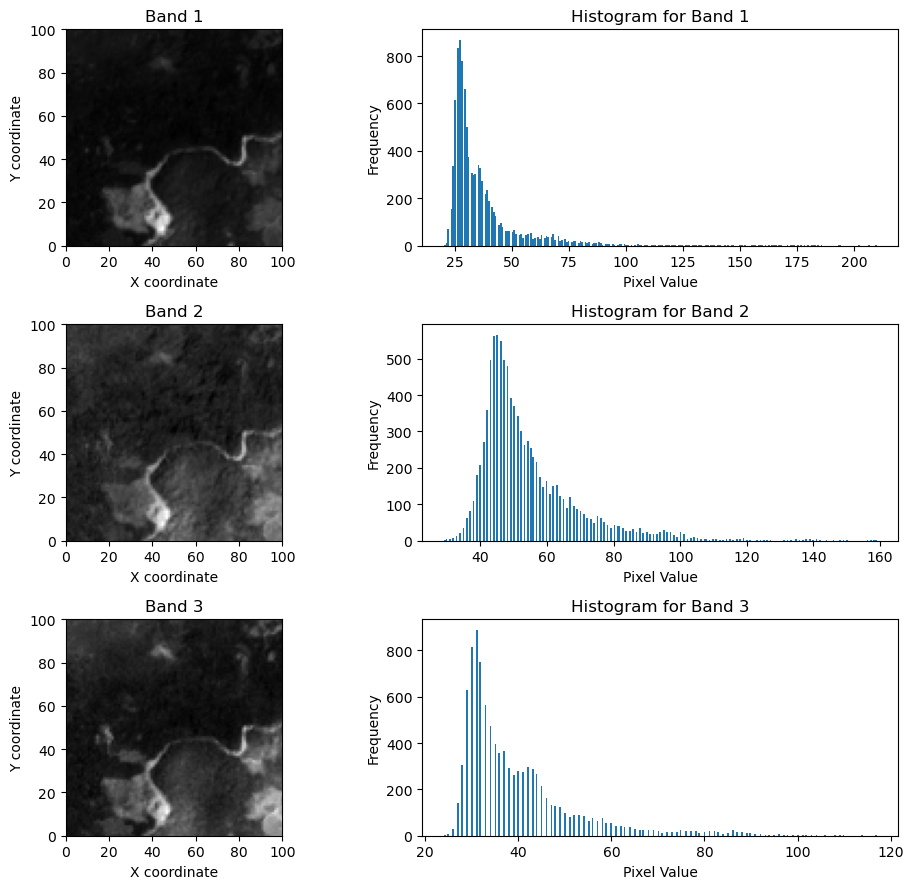

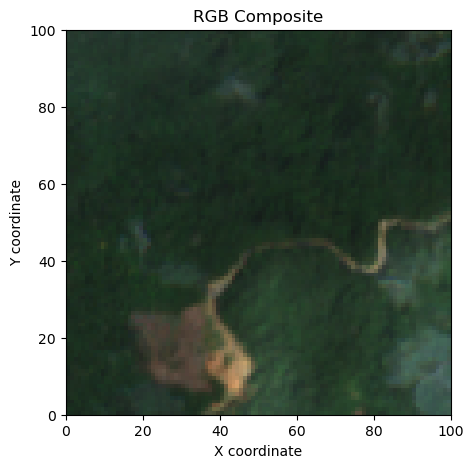

In [40]:
import os
import random
import rasterio
import matplotlib.pyplot as plt
import numpy as np

def list_tif_files(folder_path):
    return [f for f in os.listdir(folder_path) if f.endswith('.tif')]

def plot_histogram(ax, band_data, title):
    ax.hist(band_data.flatten(), bins=255)
    ax.set_title(title)
    ax.set_xlabel('Pixel Value')
    ax.set_ylabel('Frequency')

def explore_and_visualize_tif(file_path):
    with rasterio.open(file_path) as src:
        print(f"\nExploring file: {os.path.basename(file_path)}")
        print(f"Width, height: {src.width}, {src.height}")
        print(f"Data types: {tuple(src.dtypes)}")
        print(f"Coordinate Reference System: {src.crs}")
        print(f"Number of bands: {src.count}")
        print("\nMetadata:", src.meta,"\n")

        # Number of rows and columns for subplots
        ncols = 2  # Two columns for image and histogram
        nrows = src.count  # Number of rows equal to number of bands

        # Create a figure with subplots
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows * 3))

        # Visualize each band separately
        for i in range(src.count):
            band_data = src.read(i+1)
            img_ax = axes[i, 0]  # Image axis
            hist_ax = axes[i, 1]  # Histogram axis

            # Display the band image with extent to show axis scales
            extent = (0, src.width, 0, src.height)
            img_ax.imshow(band_data, cmap='gray', extent=extent)
            img_ax.set_title(f"Band {i+1}")
            img_ax.set_xlabel('X coordinate')
            img_ax.set_ylabel('Y coordinate')

            # Plot histogram for the band
            plot_histogram(hist_ax, band_data, f"Histogram for Band {i+1}")

        plt.tight_layout()
        plt.show()

        # Create a composite visualization if the image has at least 3 bands
        if src.count >= 3:
            # Read the first three bands
            red = src.read(1)
            green = src.read(2)
            blue = src.read(3)

            # Stack bands into an RGB image
            rgb = np.dstack((red, green, blue))

            # Create a new figure for the RGB composite
            plt.figure(figsize=(5, 5))
            plt.imshow(rgb, extent=extent)
            plt.title("RGB Composite")
            plt.xlabel('X coordinate')
            plt.ylabel('Y coordinate')
            plt.show()

folder_path = 'data/sentinel2rgbmedian2020.py'


tif_files = list_tif_files(folder_path)

if not tif_files:
    print("No .tif files found in the specified folder.")
else:
    print("Picking a random .tif file and exploring its content...")
    random_tif_file = random.choice(tif_files)
    file_path = os.path.join(folder_path, random_tif_file)
    explore_and_visualize_tif(file_path)


<br>

**Success!!** Remember that the order of the color channels is **RED, GREEN, BLUE** so, our band 1 is **RED**, band 2 is **GREEN** and band 3 is **BLUE**

A crude understanding of the histograms is that, the wider the histogram, the wider the presence of different **color tones for that specific channel** you will find.

Also, the darker the grayscale is for a specific image, the less that color contributes to the overall color composition of the image.

- **THE BLACKEST BLACK** is R,G,B(0,0,0), while the **whitest white** is R,G,B(255,255,255)

The original example on this notebook showcases a forest with some cloud coverage on the right side of the image. You can observe that the image is 'clearer' for the Green channel because of the higher contribution to Green for each pixel value. 

And the clouds always show themselves clear for all the three bands because the contribution to **white** on the RGB scale comes from the three color bands.

<br>

---

<br>

### **MODIS-TERRA: Understanding our rasters**

<br>

A similar strategy will be applied to our MODIS-TERRA dataset. But this time we have different expectations:

We extracted the channels `percent_tree_coverage` and `percent_nontree_vegetation`, however we applied the `visualize()` transformation at our [00_data_extraction_process](/00_data_extraction_process.MD), this transformation **creates a human viewable representation of those percentages**.

Remember that our eyes capture through the color cones the Red, Green and Blue wavelenghts of the visible spectrum. The `visualize()` function transforms  `percent_tree_coverage` and `percent_nontree_vegetation` to R,G,B values on the scale of 0-255.

Lets see how where these values transformed for this specific case:



Picking a random .tif file and exploring its content...

Exploring file: 35ffa08ffe0e2.tif
Width, height: 100, 100
Data types: ('uint8', 'uint8', 'uint8')
Coordinate Reference System: EPSG:4326
Number of bands: 3

Metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 100, 'height': 100, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(9.033860670598415e-05, 0.0, -74.7841692715202,
       0.0, -9.037068123044279e-05, 6.418192143745996)} 



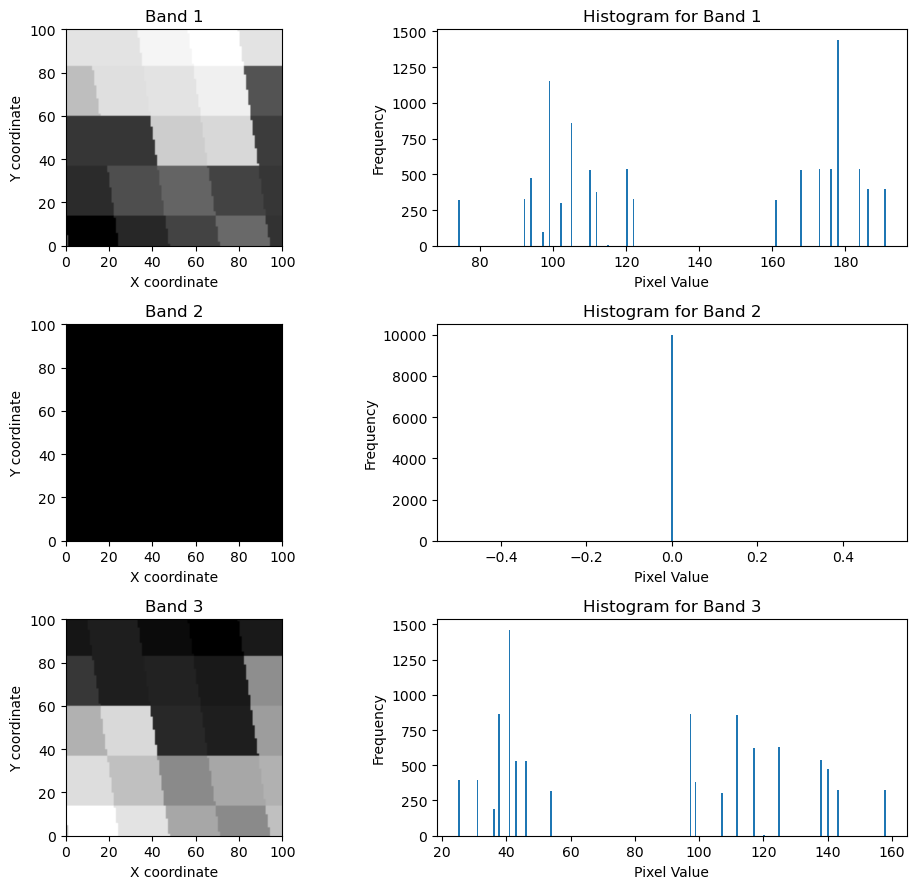

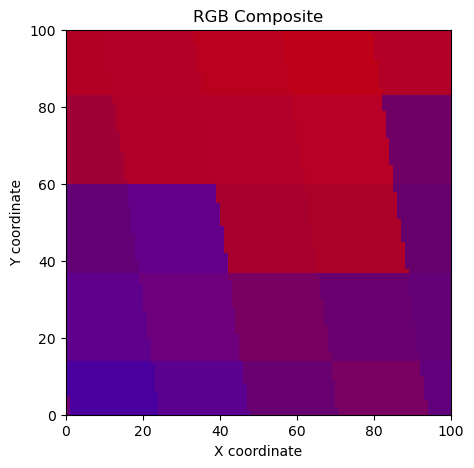

In [43]:
import os
import random
import rasterio
import matplotlib.pyplot as plt
import numpy as np

def list_tif_files(folder_path):
    return [f for f in os.listdir(folder_path) if f.endswith('.tif')]

def plot_histogram(ax, band_data, title):
    ax.hist(band_data.flatten(), bins=255)
    ax.set_title(title)
    ax.set_xlabel('Pixel Value')
    ax.set_ylabel('Frequency')

def explore_and_visualize_tif(file_path):
    with rasterio.open(file_path) as src:
        print(f"\nExploring file: {os.path.basename(file_path)}")
        print(f"Width, height: {src.width}, {src.height}")
        print(f"Data types: {tuple(src.dtypes)}")
        print(f"Coordinate Reference System: {src.crs}")
        print(f"Number of bands: {src.count}")
        print("\nMetadata:", src.meta,"\n")

        # Number of rows and columns for subplots
        ncols = 2  # Two columns for image and histogram
        nrows = src.count  # Number of rows equal to number of bands

        # Create a figure with subplots
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows * 3))

        # Visualize each band separately
        for i in range(src.count):
            band_data = src.read(i+1)
            img_ax = axes[i, 0]  # Image axis
            hist_ax = axes[i, 1]  # Histogram axis

            # Display the band image with extent to show axis scales
            extent = (0, src.width, 0, src.height)
            img_ax.imshow(band_data, cmap='gray', extent=extent)
            img_ax.set_title(f"Band {i+1}")
            img_ax.set_xlabel('X coordinate')
            img_ax.set_ylabel('Y coordinate')

            # Plot histogram for the band
            plot_histogram(hist_ax, band_data, f"Histogram for Band {i+1}")

        plt.tight_layout()
        plt.show()

        # Create a composite visualization if the image has at least 3 bands
        if src.count >= 3:
            # Read the first three bands
            red = src.read(1)
            green = src.read(2)
            blue = src.read(3)

            # Stack bands into an RGB image
            rgb = np.dstack((red, green, blue))

            # Create a new figure for the RGB composite
            plt.figure(figsize=(5, 5))
            plt.imshow(rgb, extent=extent)
            plt.title("RGB Composite")
            plt.xlabel('X coordinate')
            plt.ylabel('Y coordinate')
            plt.show()

folder_path = 'data/treecover2020.py'


tif_files = list_tif_files(folder_path)

if not tif_files:
    print("No .tif files found in the specified folder.")
else:
    print("Picking a random .tif file and exploring its content...")
    random_tif_file = random.choice(tif_files)
    file_path = os.path.join(folder_path, random_tif_file)
    explore_and_visualize_tif(file_path)

<br>

This time the composit image is blocky and doesnt conform to any instantly recognizable real world shape.

This is due to the fact that the `MODIS-TERRA` bands have a resolution of **250 meters**, while the SENTINEL-2 bands have a resolution of **10 meters**

Thus, each percentage reading from `MODIS-TERRA` is stretched to **25 times** its size to accomodate for the dimensions of the SENTINEL2 images since both datasets represent on a 100x100 image the same 1kmx1km real world terrain.

Another abnormality is that the **Green** channel is completely black with a pixel value of zero for all of the existing pixels.

What is actually happening is that the `visualize()` function transformed the `percent_tree_coverage` and `percent_nontree_vegetation` to a scale of `[0,255]` and then assigned them to the **Red** and **Blue** channels. Since we are only mapping two bands (not three), the **Green** band was left with no representation.

We will have to revert this transformation later to train our model.

<br>

---

<br>

## **Compressing and serializing our rasters**

<br>

The process of loading all images to a *trainable* representation each time we want to run the model is resource demanding. Our approach is to serialize our `X` data and our `y` target into `Pytorch.Tensors`.

However, we can not just load the images linearly, we must be sure that each `X[i]` on the `X_tensor` corresponds with the target value at `y[i]` on the `y_tensor`.

`Tensors` are memory and execution-optimized objects that are compatible with  `GPU Processing`.  We choose them because we will later find that they allow us to reduce the size of our data almost  by ~20 factors!

Luckily, the `GEETILES` tool creates a name encoding specific for each **area coordinates**, thus ensuring us that there is a specific namefile that relates two tiles from both dataset with each other. (i.e there is exactly one `35ffa08ffe0e2.tif` on `Sentinel2` directory and there is exactly one `35ffa08ffe0e2.tif` on `MODIS-TERRA` directory). We must only pair the images using their name as reference, and since both datasets contains the exact number of images, no `X` **row** or `y` **target** will be left alone.


So, our tasks right now are to:

1. Load the images
2. Reverse the `visualize()` transformation to get a single `percent_vegetation` value from `[0, 100]`
3. Pair the images from both datasets.
4. To not lose information, we will save the `metadata` from the images to a different `JSON` file.

To do this, we use the script available at [src/dataset_serialization/serialize_sentinel_vegetation_data.py](src/dataset_serialization/serialize_sentinel_vegetation_data.py), as usual we will put the content below to run it from within this notebook:


In [44]:
# Importing required libraries
import os
import json
import torch
import rasterio
import numpy as np
from tqdm import tqdm

# Function to read and process a single .tif file for 'y'
def read_and_process_tif_file_for_y(filepath):
    with rasterio.open(filepath) as src:
        # Read the bands 1 and 3, skipping the empty band 2
        band1, band3 = src.read(1), src.read(3)
        
        # Apply the transformation to scale the values between 0 and 100
        band1 = (band1 / 255.0) * 100
        band3 = (band3 / 255.0) * 100
        
        # Calculate Percent_Vegetation_Coverage and clip it to be between 0 and 100
        percent_vegetation_coverage = np.clip(band1 + band3, 0, 100)
        
        # Calculate a single Percent_Vegetation_Coverage value for the entire image (e.g., mean)
        single_value = np.mean(percent_vegetation_coverage)
        
        return single_value, src.meta


# Function to read a single .tif file and return as numpy array
def read_tif_file(filepath):
    with rasterio.open(filepath) as src:
        return np.array(src.read()), src.meta

# Function to save metadata to a JSON file
def save_metadata(metadata_dict, save_path):
    for meta in metadata_dict:
        if 'sentinel_meta' in meta and 'crs' in meta['sentinel_meta']:
            meta['sentinel_meta']['crs'] = str(meta['sentinel_meta']['crs'])
        if 'treecover_meta' in meta and 'crs' in meta['treecover_meta']:
            meta['treecover_meta']['crs'] = str(meta['treecover_meta']['crs'])
    with open(save_path, 'w') as f:
        json.dump(metadata_dict, f)


# Initialize empty lists to store images and metadata
X_images = []
y_images = []
metadata_list = []


### ---------------------------- ###

# Directory paths
sentinel_dir = 'data/sentinel2rgbmedian2020.py'  # Replace with your actual directory
treecover_dir = 'data/treecover2020.py'  # Replace with your actual directory

### ---------------------------- ###


# File names are assumed to be the same in both directories
filenames = os.listdir(sentinel_dir)

# Loop through each file and read the image and metadata
for filename in tqdm(filenames):
    # Read SENTINEL-2 image
    sentinel_path = os.path.join(sentinel_dir, filename)
    sentinel_img, sentinel_meta = read_tif_file(sentinel_path)
    
    # Read and process Tree Cover image
    treecover_path = os.path.join(treecover_dir, filename)
    percent_vegetation_coverage, treecover_meta = read_and_process_tif_file_for_y(treecover_path)
    
    # Append to lists
    X_images.append(sentinel_img)
    y_images.append(percent_vegetation_coverage)
    metadata_list.append({
        'filename': filename,
        'sentinel_meta': sentinel_meta,
        'treecover_meta': treecover_meta
    })

# Convert lists to PyTorch tensors
X_tensor = torch.tensor(np.stack(X_images, axis=0))
y_tensor = torch.tensor(np.stack(y_images, axis=0), dtype=torch.float32)

# Serialize tensors and save to disk
torch.save(X_tensor, 'X_tensor.pth')
torch.save(y_tensor, 'y_tensor.pth')

# Save metadata to JSON file
save_metadata(metadata_list, 'metadata.json')

print("Data preparation and serialization complete.")


100%|██████████| 64106/64106 [02:55<00:00, 364.68it/s]


Data preparation and serialization complete.


<br>

This process is entirely **RAM** and **CPU** dependant and its not done in batches or parallelized.

Expect loading times **a lot higher** if you cant load all the data in **RAM**.

<br>

<br>

---

<br>

## **Understanding our Tensor Datasets**

<br>

Before we wrap up this notebook, lets explore our `Tensors`.

The script to do this from the terminal is located at [analyze_training_tensors.py](analyze_training_tensors.py)

As usual, the same code is provided below:

In [46]:
import torch



# Change tensor's file name

X_name = "X_tensor.pth"
y_name = "y_tensor.pth"


# Load the tensors from disk

x_tensor = torch.load(X_name)
y_tensor = torch.load(y_name)

# Print the shapes and data types of the tensors
print("Shape of X_tensor:", x_tensor.shape)
print("Data type of X_tensor:", x_tensor.dtype)
print("Number of elements in X_tensor:", torch.numel(x_tensor))

print("Shape of y_tensor:", y_tensor.shape)
print("Data type of y_tensor:", y_tensor.dtype)
print("Number of elements in y_tensor:", torch.numel(y_tensor))

# Calculate the size in bytes
print("Size of X_tensor in bytes:", x_tensor.element_size() * x_tensor.nelement())
print("Size of y_tensor in bytes:", y_tensor.element_size() * y_tensor.nelement())


Shape of X_tensor: torch.Size([64106, 3, 100, 100])
Data type of X_tensor: torch.uint8
Number of elements in X_tensor: 1923180000
Shape of y_tensor: torch.Size([64106])
Data type of y_tensor: torch.float32
Number of elements in y_tensor: 64106
Size of X_tensor in bytes: 1923180000
Size of y_tensor in bytes: 256424


<br>

---

## **NEXT STEPS**

<BR>

Please go to the [02_training_process.ipynb](02_training_process.ipynb) to see how the models were implemented